In [ ]:
# https://gist.github.com/craffel/2d727968c3aaebd10359
# https://medium.com/@jorgesleonel/backpropagation-cc81e9c772fd
# * https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65
# * https://colab.research.google.com/drive/10y6glU28-sa-OtkeL8BtAtRlOITGMnMw#scrollTo=oTrTMpTwtLXd
# https://heartbeat.fritz.ai/classification-with-tensorflow-and-dense-neural-networks-8299327a818a
# https://medium.com/@a.mirzaei69/implement-a-neural-network-from-scratch-with-python-numpy-backpropagation-e82b70caa9bb

In [ ]:
import numpy as np
import pandas as pd
np.random.seed(42)

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
class FCLayer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) / np.sqrt(input_size + output_size)
        self.bias = np.random.randn(1, output_size) / np.sqrt(input_size + output_size)

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

    def getWeights(self):
        return self.weights

In [ ]:
class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forward(self, input):
        self.input = input
        return self.activation(input)
    
    def backward(self, output_error, learning_rate):
        return output_error * self.activation_prime(self.input)

    def getWeights(self):
        return None

In [ ]:
class FlattenLayer:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def forward(self, input):
        return np.reshape(input, (1, -1))
    
    def backward(self, output_error, learning_rate):
        return np.reshape(output_error, self.input_shape)

    def getWeights(self):
        return None

In [ ]:
class SoftmaxLayer:
    def __init__(self, input_size):
        self.input_size = input_size
    
    def forward(self, input):
        self.input = input
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_error, learning_rate):
        input_error = np.zeros(output_error.shape)
        out = np.tile(self.output.T, self.input_size)
        return self.output * np.dot(output_error, np.identity(self.input_size) - out)
    
    def getWeights(self):
        return None

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return np.exp(-x) / (1 + np.exp(-x))**2


def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.tanh(x)**2


def relu(x):
    return np.maximum(x, 0)

def relu_prime(x):
    return np.array(x >= 0).astype('int')


def linear(x):
  return x

def linear_prime(x):
  return 1

In [ ]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return (y_pred - y_true) / y_pred.size

def sse(y_true, y_pred):
    return 0.5 * np.sum(np.power(y_true - y_pred, 2))

def sse_prime(y_true, y_pred):
    return y_pred - y_true

In [ ]:
def hotEncode(target, nCat):
  oneHot = [0]*nCat
  oneHot[target] = 1
  return oneHot

In [ ]:
def forwardPropogation(network, input):
  output = input
  for layer in network:
    output = layer.forward(output)
  
  return output[0]

In [ ]:
def backPropogation(network, target, output, costFunction, learning_rate = 0.1):

  actual = hotEncode(target, len(output))
  output_error = costFunction(actual, output)

  for layer in reversed(network):
    output_error = layer.backward(output_error, learning_rate)

  return network

In [ ]:
def predict(network, input):
    return np.argmax(forwardPropogation(network, input))

In [ ]:
def plotNetwork(layerSizes, layerTypes, dim = [.1, .9, .1, .9]):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    ax.axis('off')
    
    n_layers = len(layerSizes)
    left, right, bottom, top = dim
    verticalSpacing = (top - bottom)/float(max(layerSizes))
    horizontalSpacing = (right - left)/float(len(layerSizes) - 1)

    def getLayerTop(verticalSpacing, layerSize, top, bottom):
        return verticalSpacing*(layerSize - 1)/2 + (top + bottom)/2

    
    dic = {'input':'blue', 'sigmoid':'green', 'relu':'orange', 'softmax':'purple', 'linear':'red'}

    # Nodes
    for n, layerSize in enumerate(layerSizes):
        y = verticalSpacing/4
        c = dic[layerTypes[n]]
        layerTop =  getLayerTop(verticalSpacing, layerSize, top, bottom)
        for m in range(layerSize):

            x = (n*horizontalSpacing + left, layerTop - m*verticalSpacing)
            
            circle = plt.Circle(x, y, color=c, ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layerSizeA, layerSizeB) in enumerate(zip(layerSizes[:-1], layerSizes[1:])):
        layerTopA = getLayerTop(verticalSpacing, layerSizeA, top, bottom)
        layerTopB = getLayerTop(verticalSpacing, layerSizeB, top, bottom) 

        x = [n*horizontalSpacing + left, (n + 1)*horizontalSpacing + left]
        for m in range(layerSizeA):
            originY = layerTopA - m*verticalSpacing
            for o in range(layerSizeB):
                y = [originY, layerTopB - o*verticalSpacing]
                line = plt.Line2D(x, y, c='k')
                ax.add_artist(line)

    
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in dic.values()]
    ax.legend(markers, dic.keys(), prop={'size': 15})
    return fig

In [ ]:
def testNetwork(network, X_test, Y_test):

  Y_estimate = [0]*len(Y_test)
  
  for i, x in enumerate(X_test):
    Y_estimate[i] = predict(network, x)

  metrics = {}
  metrics['confMatrix'] = confusion_matrix(Y_test, Y_estimate)                                                  # Generate confusion matrix
  metrics['percision'] = precision_score(Y_test, Y_estimate, average = 'weighted', labels=np.unique(Y_estimate))# Generate percision score
  metrics['accuracy'] = accuracy_score(Y_test, Y_estimate)                                                      # Generate accuracy score
  metrics['recall'] = recall_score(Y_test, Y_estimate, average = 'weighted')                                    # Generate recall score
  metrics['f1Score'] = f1_score(Y_test, Y_estimate, average = 'weighted')                                       # Generate F1 score

  return metrics

# Helper/utility function for printing metrics dictionary
def printMetricTest(epoch, metrics):

  def percent(value):
    return str(round(value*100, 2))+'%'

  print("        -At epoch number: "+str(epoch)+"-      ")

  print("-------------------------------------")

  print("Percision: ", percent(metrics['percision']))
  print("Accuracy: ", percent(metrics['accuracy']))
  print("Recall: ", percent(metrics['recall']))
  print("F1: ", percent(metrics['f1Score']))

  print("Confusion Matrix: ")
  cmtx = pd.DataFrame(metrics['confMatrix'], 
    index=['true: 0', 'true: 1', 'true: 2'], 
    columns=['pred: 0', 'pred: 1', 'pred: 2'])
  print(cmtx)

  print("*************************************")

In [ ]:
def getNetworkWeights(network):
  weights = []
  for layer in network:
    layerWeights = layer.getWeights()
    layerWeights = list(np.array(layerWeights).flat)
    weights = np.hstack((weights, layerWeights))
  return weights

In [ ]:
# The three functions below are for storing values in large arrays, will later be recoded to save in a file (json or simple array txt)

# Record the weights of the classifier in an array
def getWeightRecord(weights):
  #allWeights = np.reshape(weights, len(weights)*len(weights[0]))
  return weights #allWeights

# Record the metrics of the classifier in an array
def getMetricsRecord(metrics):
  return [metrics['accuracy'], metrics['percision'], metrics['recall'], metrics['f1Score']]

# Helper/utility function for stacking array
def stackData(allData, newRow):
  return np.vstack([allData, newRow])

In [ ]:
iris = load_iris() # loads the iris data set from sklearn

X = iris.data   # loads independent variables from dataset
Y = iris.target # loads dependent variables from dataset

X = MinMaxScaler().fit(X).transform(X) # Normalizes features of the Iris data set
#X = StandardScaler().fit(X).transform(X) # Standardizes features of the Iris data set  
# Y values are categorical and do not need standerdizing

seed = 42 # RNG seed for the train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state= seed)
# Split the data into a set of training and testing sets

In [ ]:
def getNetwork(nFeatures= 4, nNeurons= 3, function= sigmoid, functionPrime= sigmoid_prime, nTargets= 3):
    dic = {sigmoid:'sigmoid', relu:'relu', linear:'linear', tanh:'tanh'}
    
    layerSizes = [nFeatures, nNeurons, nTargets]
    layerTypes = ['input', dic[function], 'softmax']

    network = [FlattenLayer(input_shape=(1, nFeatures)),
               
               FCLayer(nFeatures, nNeurons), 
               ActivationLayer(function, functionPrime),

               FCLayer(nNeurons, nTargets),
               SoftmaxLayer(nTargets)]

    return network, layerSizes, layerTypes

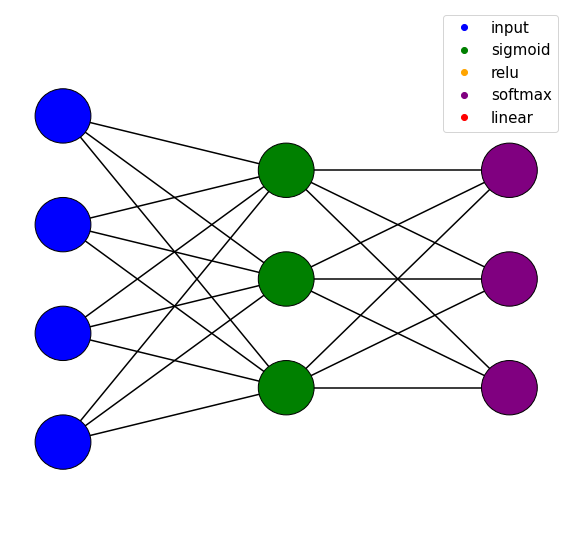

In [ ]:
network, layerSizes, layerTypes = getNetwork(nFeatures= 4, nNeurons= 3, function= sigmoid, functionPrime= sigmoid_prime, nTargets= 3)

fig = plotNetwork(layerSizes, layerTypes)
fig.savefig('nn.png')

In [ ]:
def trainNetwork(network, X_train, Y_train, X_test, Y_test, nEpochs=5, learning_rate = 0.1, display = False):

  weights = getNetworkWeights(network)
  metrics = testNetwork(network, X_test, Y_test)
  printMetricTest(0, metrics) if display else None

  weightData = getWeightRecord(weights)
  metricData = getMetricsRecord(metrics)

  for epoch in range(nEpochs):
    for x, y in zip(X_train, Y_train):

        # forward
        output = forwardPropogation(network, x)

        # backward
        network = backPropogation(network, y, output, sse_prime, learning_rate)

        weights = getNetworkWeights(network)
        metrics = testNetwork(network, X_test, Y_test)
        weightData = stackData(weightData, getWeightRecord(weights))
        metricData = stackData(metricData, getMetricsRecord(metrics))

    printMetricTest(epoch+1, metrics) if display else None

  wDf = pd.DataFrame(weightData)
  mDf = pd.DataFrame(metricData, columns=['accuracy', 'percision', 'recall', 'f1Score'])
  return network, wDf, mDf

In [ ]:
network, wDf, mDf = trainNetwork(network, X_train, Y_train, X_test, Y_test, nEpochs= 13, display= True)

        -At epoch number: 0-      
-------------------------------------
Percision:  24.08%
Accuracy:  31.58%
Recall:  31.58%
F1:  19.94%
Confusion Matrix: 
         pred: 0  pred: 1  pred: 2
true: 0        0       12        3
true: 1        0        0       11
true: 2        0        0       12
*************************************
        -At epoch number: 1-      
-------------------------------------
Percision:  31.58%
Accuracy:  31.58%
Recall:  31.58%
F1:  15.16%
Confusion Matrix: 
         pred: 0  pred: 1  pred: 2
true: 0        0        0       15
true: 1        0        0       11
true: 2        0        0       12
*************************************
        -At epoch number: 2-      
-------------------------------------
Percision:  31.58%
Accuracy:  31.58%
Recall:  31.58%
F1:  15.16%
Confusion Matrix: 
         pred: 0  pred: 1  pred: 2
true: 0        0        0       15
true: 1        0        0       11
true: 2        0        0       12
*********************************

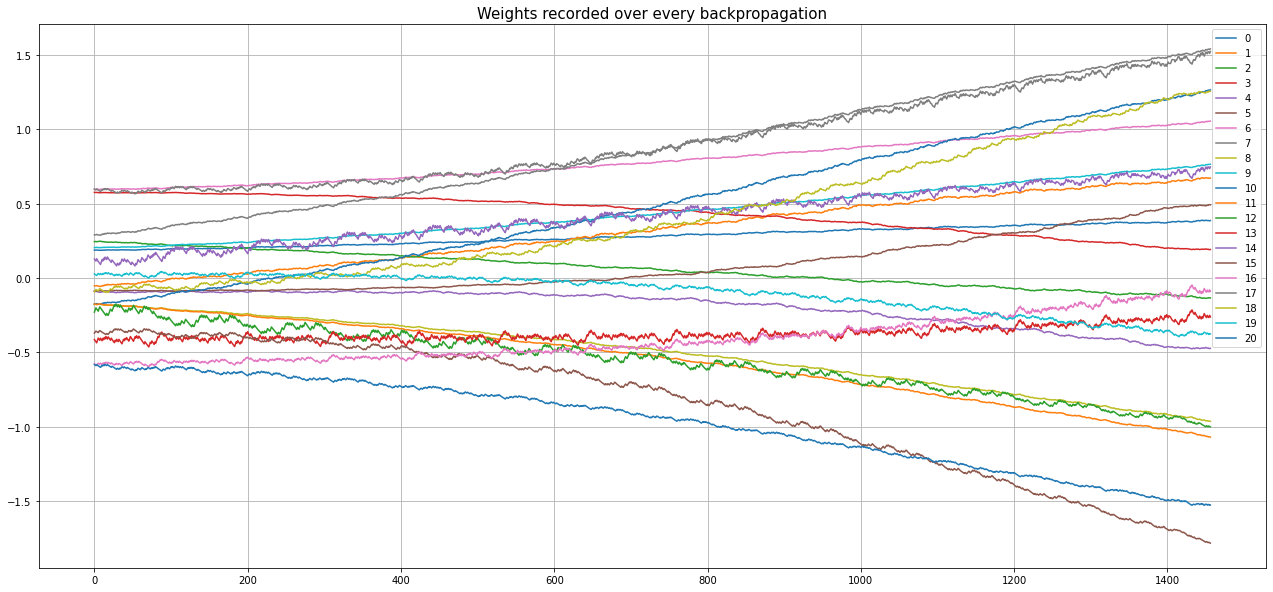

In [ ]:
wDf.columns = wDf.columns.astype(str)
wDf = wDf.drop(['0','13','23'], axis=1)
wDf.columns = [str(i) for i in range(24-3)]
wDf.plot(figsize=(22,10), title= 'Weights recorded over every backpropagation', grid=True).title.set_size(15)

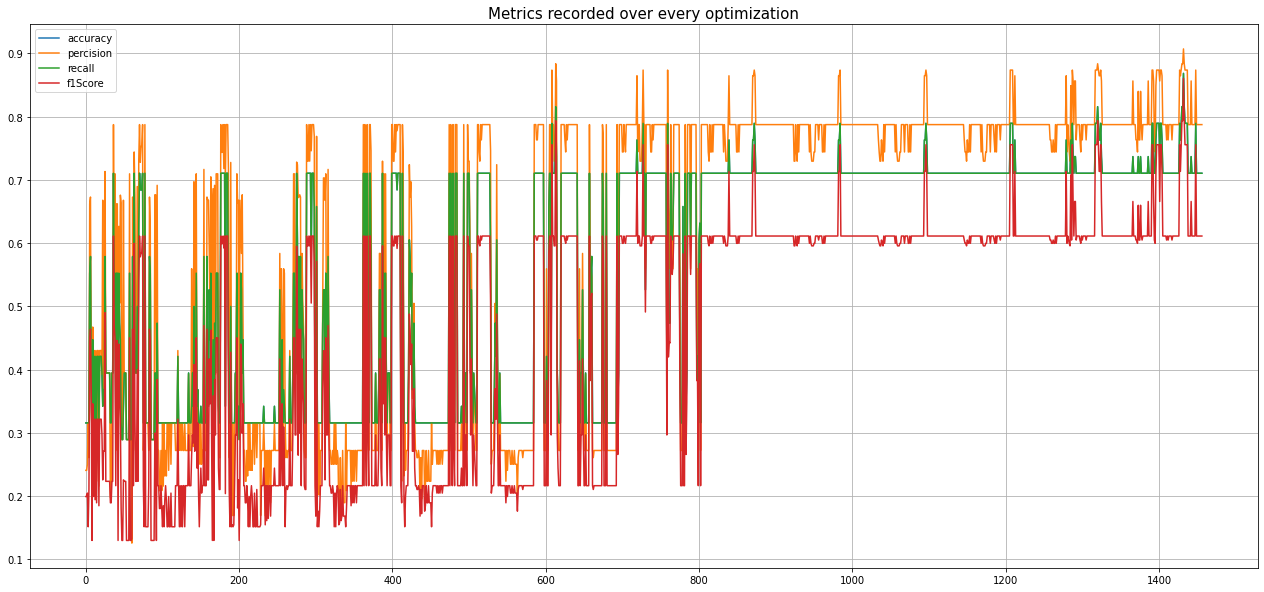

In [ ]:
mDf.plot(figsize=(22,10), title= 'Metrics recorded over every optimization', grid=True).title.set_size(15)

In [ ]:
# The four functions below are for calculating basic statistical information in colums of data or dataframes

# Calculate statistics for a one dimensional array of data
def getStats(col):
  stats = {}
  stats['minimum'] = min(col)
  stats['maximum'] = max(col)
  stats['mean'] = sum(col) / len(col)
  stats['var'] = sum((i - stats['mean']) ** 2 for i in col) / len(col)
  return stats # Returns a dictionary

# Calculate statistics for every column in a dataframe
def getAllStats(df):
  allStats = {}
  for col in df:
    allStats[col+'Stats'] = getStats(df[col])
  return allStats # Returns a dictionary of dictionaries

# Prints the statistics from a one dimensional array stored in a dictionary
def printStats(stats):
  print("minimum value: ", stats['minimum'])
  print("maximum value: ", stats['maximum'])
  print("average value: ", stats['mean'])
  print("variance value: ", stats['var'])

# Print the statistics from a dataframe stored in a dictionary of dictionaries
def printAllStats(dictionary):
  for key in dictionary:
    print("Column ", "-"+key+"-", " information")
    printStats(dictionary[key])
    print("**********************************************")

In [ ]:
# Create 'synthetic' features to outline the classifier's decision making process
def prodSynthData(X, network, names, nPoints = 10, buffer = 0.1):
  
  _, nFeatures = X.shape
  synthFeatures = [0]*nFeatures

  # 10^n data points are produced, where n is the number of features
  synthData = np.zeros((nPoints**nFeatures, nFeatures+1), float)

  # Each column of synthetic features will range from slightly smaller than the smallest value in that column and vice versa for the largest
  for n in range(nFeatures):
    feat_min, feat_max = X[:, n].min() - buffer, X[:, n].max() + buffer
    synthFeatures[n] = np.linspace(feat_min, feat_max, num= nPoints)

  i = 0
  for val_0 in synthFeatures[0]:
    for val_1 in synthFeatures[1]:
      for val_2 in synthFeatures[2]:
        for val_3 in synthFeatures[3]:  
          # Iterate through every possible combination of the features and classify them
          classification = predict(network, [val_0, val_1, val_2, val_3])
          synthData[i] = [val_0, val_1, val_2, val_3, classification]
          i= i+1

  return pd.DataFrame(synthData, columns= names) # Return the 'synthetic' features and classifications as a dataframe

# Helper/utility function to get statistics on the 'synthetic' classifications made in the previous function
def getTargetStats(df, targetName, target):
  df = df[df[targetName] == target]
  df = df.drop([targetName], axis=1)
  allStats = getAllStats(df)
  return allStats

In [ ]:
# Produce 'synthetic' features and classifications
synthNames = ['SepalL', 'SepalW', 'PetalL', 'PetalW', 'SynthPrediction']
synthFlowers = prodSynthData(X, network, synthNames, nPoints= 15)

# Rename imported/'real' features and known/'actual' classifications as a dataframe
realFlowers = pd.DataFrame(X, columns=['SepalL', 'SepalW', 'PetalL', 'PetalW'])
realFlowers['ActualFlower'] = Y

In [ ]:
# Print the first few and last few rows for inspection
print(synthFlowers)

       SepalL  SepalW  PetalL    PetalW  SynthPrediction
0        -0.1    -0.1    -0.1 -0.100000              0.0
1        -0.1    -0.1    -0.1 -0.014286              0.0
2        -0.1    -0.1    -0.1  0.071429              0.0
3        -0.1    -0.1    -0.1  0.157143              0.0
4        -0.1    -0.1    -0.1  0.242857              0.0
...       ...     ...     ...       ...              ...
50620     1.1     1.1     1.1  0.757143              2.0
50621     1.1     1.1     1.1  0.842857              2.0
50622     1.1     1.1     1.1  0.928571              2.0
50623     1.1     1.1     1.1  1.014286              2.0
50624     1.1     1.1     1.1  1.100000              2.0

[50625 rows x 5 columns]


In [ ]:
# Graph the correlation matrix of a dataframe using one-hot encoding for categorical target
def graphCorrelations(df, targetName, fName = 'Correlation Matrix'):
  hot = pd.get_dummies(df[targetName])# , prefix='flower '
  df = pd.concat([df, hot], axis=1)
  df = df.drop([targetName], axis=1)

  corr = df.corr()

  mask = np.zeros_like(corr, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  plt.subplots(figsize=(12, 11))

  sns.heatmap(round(corr,2), mask= mask, 
              cmap= sns.diverging_palette(220, 10, as_cmap=True), 
              annot=True, vmax=1, vmin=-1, center=0, square=True, 
              linewidths=.8, cbar_kws={"shrink": .8})
  
  plt.title(fName, fontsize=15)

# Graph a heat map from the perspective of the features, 3 dimensional histogram with counts in the z axis but represented by contours
def heatMap(realXFeature, realYActual, synthXFeature, synthYPrediction):
  fig, ax = plt.subplots(figsize=(11, 9))
  sns.kdeplot(ax=ax, x= synthXFeature, y= synthYPrediction, cmap= "Reds", shade=False, thresh=False)
  sns.kdeplot(ax=ax, x= realXFeature, y= realYActual, cmap= "YlOrBr", shade=False, thresh=False)
  plt.title("NN 2D KDE Elevation & Relief Map: Real Flowers-Yellow & Synthetic Flowers-Red", fontsize=15)
  plt.ylabel('Flower Classification')
  

# Graph a two dimensional histogram from the perspective of the target
def targetPlot(df, targetName, target, colorArr):
  df = df[df[targetName] == target]
  df = df.drop([targetName], axis=1)
  fig, ax = plt.subplots(figsize=(10, 9))
  for i, col in enumerate(df):
    sns.kdeplot(ax=ax, data=df[col], color=colorArr[i], shade=False, Label=col)
  plt.title('Kernel Density Estimate: Iris '+str(target)).set_size(15)
  plt.legend()
  plt.xlabel('Feature Values')
  plt.ylabel('Density Estimate')
  plt.show()

def pairPlot(df, targetName, fName):
  sns.set()
  graph = sns.pairplot(data= df, hue= targetName, diag_kind="kde", diag_kws=dict(fill=False), markers=["o", "s", "D"])
  graph.fig.suptitle(fName, y= 1.01, fontsize= 18)

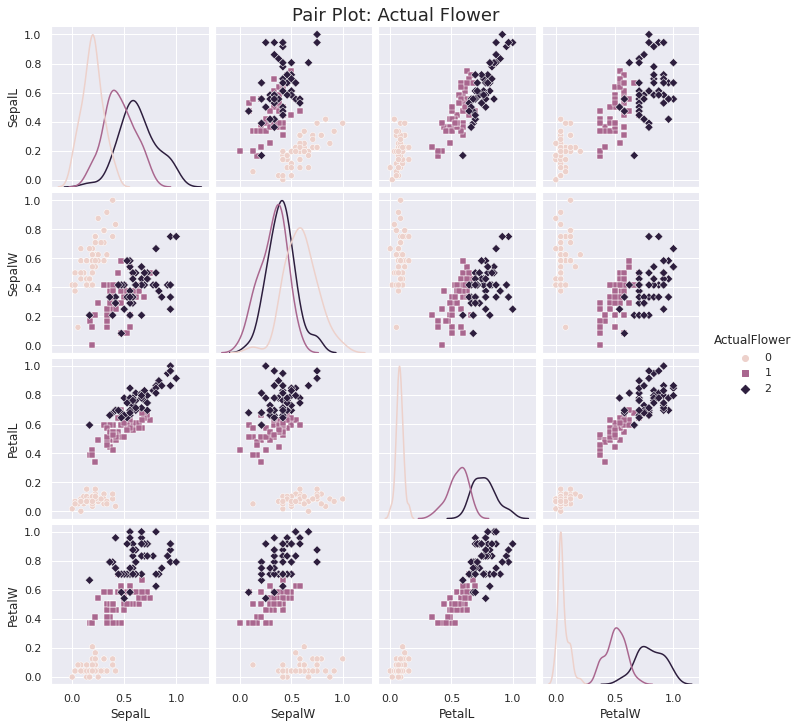

In [ ]:
pairPlot(realFlowers, 'ActualFlower', 'Pair Plot: Actual Flower')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


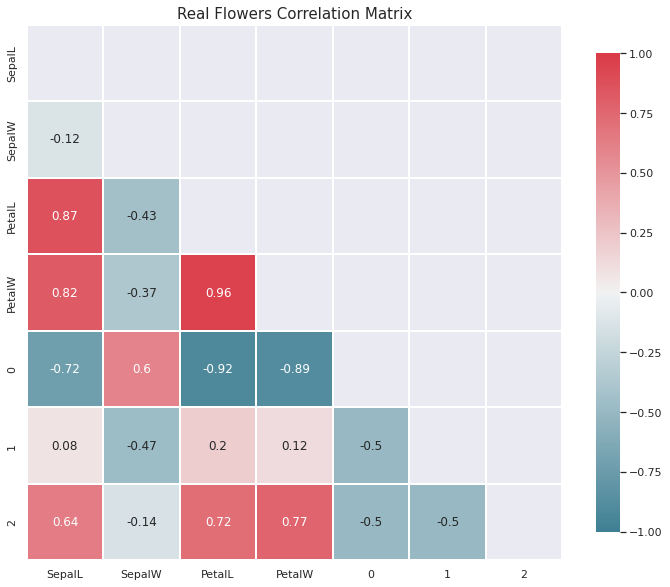

In [ ]:
graphCorrelations(realFlowers, 'ActualFlower', fName ='Real Flowers Correlation Matrix')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


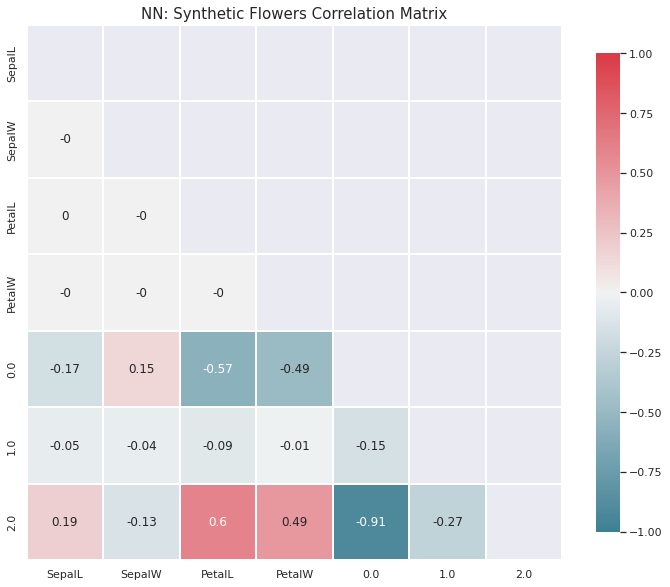

In [ ]:
graphCorrelations(synthFlowers, 'SynthPrediction', fName ='NN: Synthetic Flowers Correlation Matrix')

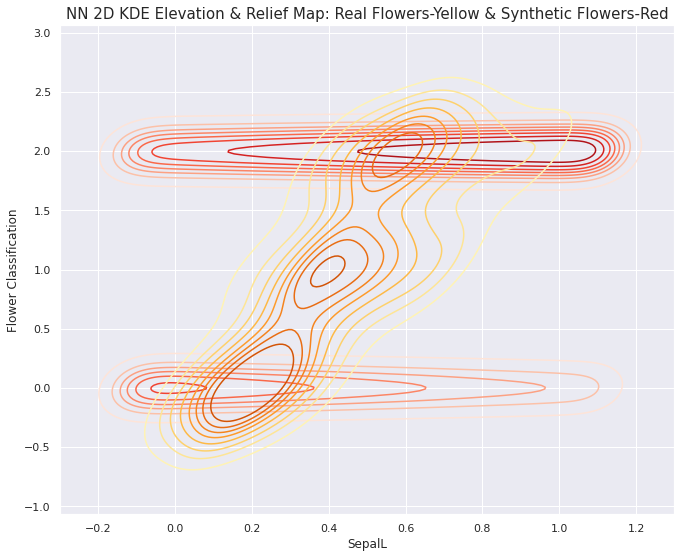

In [ ]:
heatMap(realFlowers['SepalL'], realFlowers['ActualFlower'], synthFlowers['SepalL'], synthFlowers['SynthPrediction'])

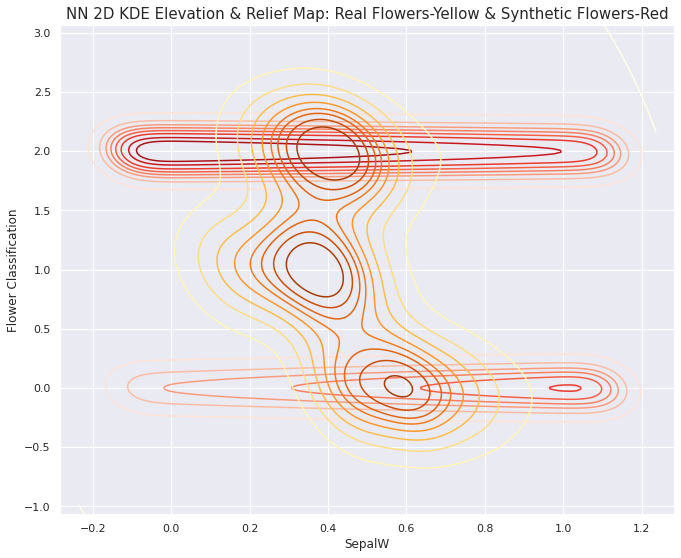

In [ ]:
heatMap(realFlowers['SepalW'], realFlowers['ActualFlower'], synthFlowers['SepalW'], synthFlowers['SynthPrediction'])

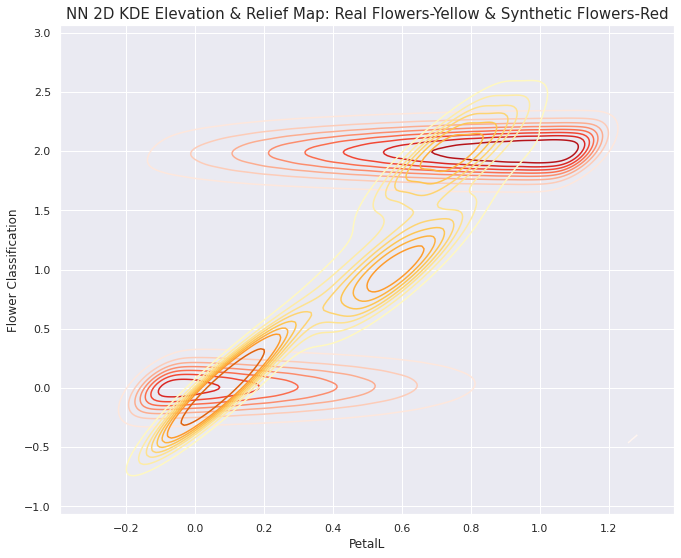

In [ ]:
heatMap(realFlowers['PetalL'], realFlowers['ActualFlower'], synthFlowers['PetalL'], synthFlowers['SynthPrediction'])

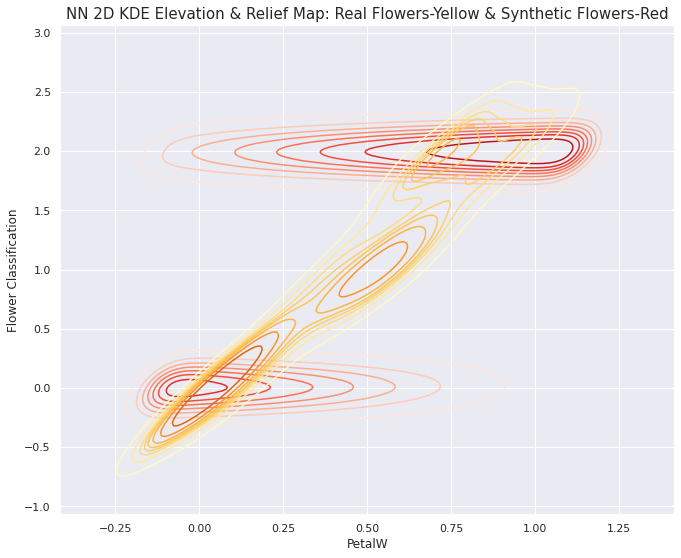

In [ ]:
heatMap(realFlowers['PetalW'], realFlowers['ActualFlower'], synthFlowers['PetalW'], synthFlowers['SynthPrediction'])

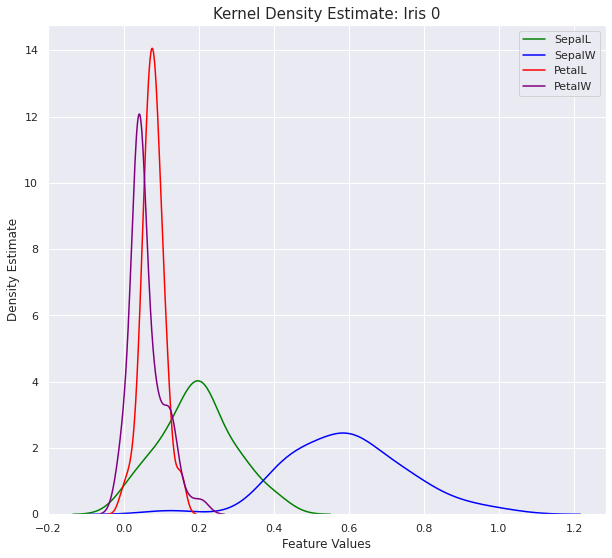

In [ ]:
targetPlot(realFlowers, 'ActualFlower', 0, colorArr = ['green', 'blue', 'red', 'purple'])

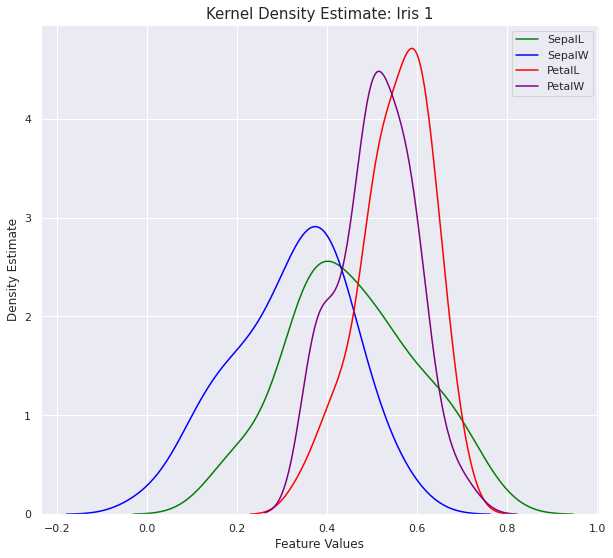

In [ ]:
targetPlot(realFlowers, 'ActualFlower', 1, colorArr = ['green', 'blue', 'red', 'purple'])

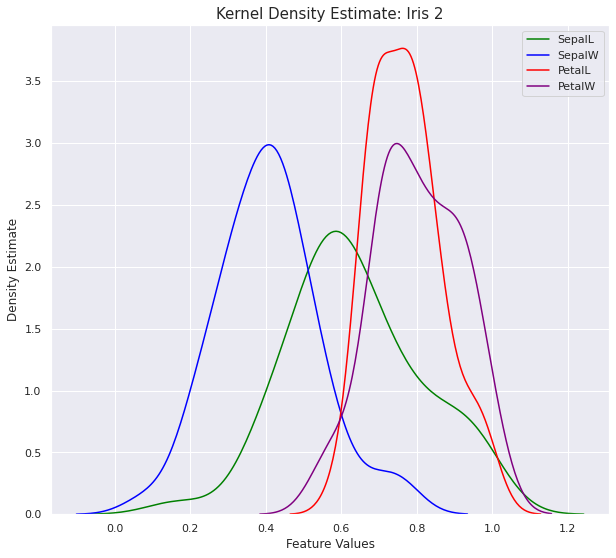

In [ ]:
targetPlot(realFlowers, 'ActualFlower', 2, colorArr = ['green', 'blue', 'red', 'purple'])

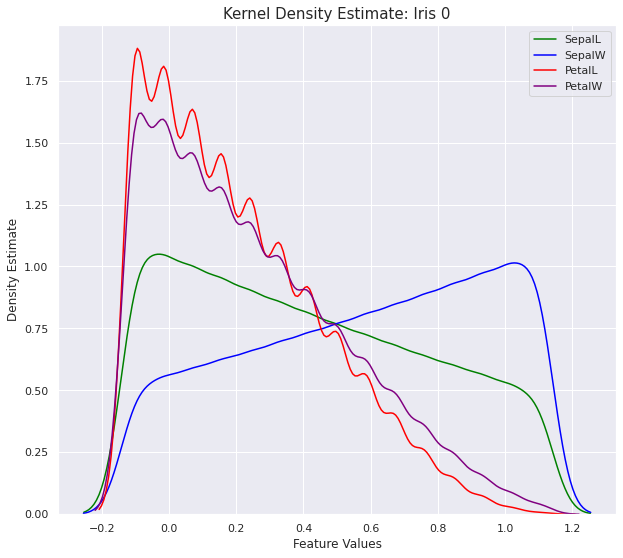

In [ ]:
targetPlot(synthFlowers, 'SynthPrediction', 0, colorArr = ['green', 'blue', 'red', 'purple'])

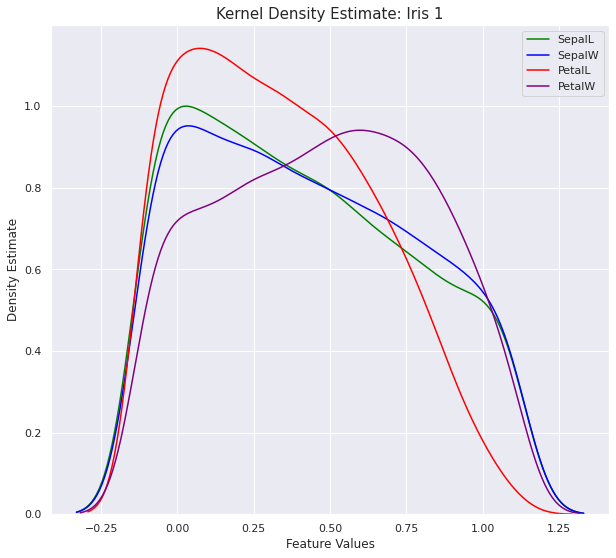

In [ ]:
targetPlot(synthFlowers, 'SynthPrediction', 1, colorArr = ['green', 'blue', 'red', 'purple'])

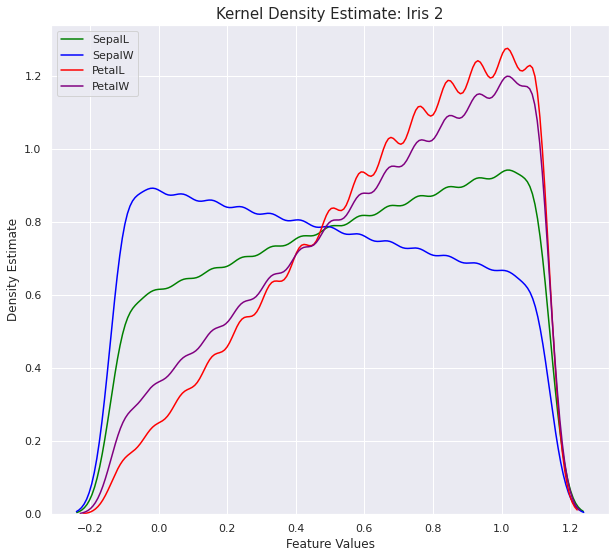

In [ ]:
targetPlot(synthFlowers, 'SynthPrediction', 2, colorArr = ['green', 'blue', 'red', 'purple'])